In [60]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle

from datetime import datetime, timedelta

plt.style.use('bmh')
mpl.rcParams['figure.figsize'] = (9,5)
mpl.rcParams['lines.linewidth'] = 1.5

%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
with open('../data/WETH_USDC_pool_swap-2024-02-02_2024-01-31.pkl', 'rb') as fp:
    data = pickle.load(fp)

In [43]:
len(data['sender'].unique())

112

In [5]:
data.columns

Index(['amount0', 'amount1', 'amountUSD', 'origin', 'sender', 'recipient',
       'timestamp', 'symbol0', 'symbol1', 'price'],
      dtype='object')

In [6]:
numeric_cols = ['amount0', 'amount1', 'amountUSD', 'timestamp', 'price']
data[numeric_cols] = data[numeric_cols].astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500000 entries, 2024-02-02 03:38:23 to 2024-01-31 23:35:35
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   amount0    500000 non-null  float64
 1   amount1    500000 non-null  float64
 2   amountUSD  500000 non-null  float64
 3   origin     500000 non-null  object 
 4   sender     500000 non-null  object 
 5   recipient  500000 non-null  object 
 6   timestamp  500000 non-null  float64
 7   symbol0    500000 non-null  object 
 8   symbol1    500000 non-null  object 
 9   price      500000 non-null  float64
dtypes: float64(5), object(5)
memory usage: 42.0+ MB


In [7]:
# data.to_csv('data/WETH_USDC_pool_swap-2024-02-02_2024-01-31.csv')

In [8]:
data.head()

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,symbol0,symbol1,price
time,,,,,,,,,,
2024-02-02 03:38:23,-2301.902031,1.000000,2303.241969,0xfa1fe308a3d99c2b6a6bb73eddcf7c550dec7b39,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706845e+09,USDC,WETH,2303.10974
2024-02-02 03:38:11,-46.038173,0.020000,46.064906,0x1229966c7ea6dbaf6cb2d1227d9206da6046dc46,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0xce16f69375520ab01377ce7b88f5ba8c48f8d666,1.706845e+09,USDC,WETH,2303.10974
2024-02-02 03:37:11,-1543.971264,0.670734,1544.866258,0xcbd505c41eebd424156fc466cfe1e56e038d0d20,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0xcbd505c41eebd424156fc466cfe1e56e038d0d20,1.706845e+09,USDC,WETH,2303.10974
2024-02-02 03:36:23,3380.000000,-1.466879,3380.271571,0x1571929fe6d51bd7d6538939d81fa389a3c19d55,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706845e+09,USDC,WETH,2303.10974
2024-02-02 03:36:23,-259.266374,0.112632,259.417456,0xf9e032cb55d0dc4e3754dce32beee23b9981773c,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xf9e032cb55d0dc4e3754dce32beee23b9981773c,1.706845e+09,USDC,WETH,2303.10974


In [83]:
from AMMSimulator import *

# Define a simple fees model
class SimpleTransactFeesModel(ITransactFeesModel):
    def calculate(self, trader: Trader, new_order: Transaction):
        fees_factor = max(0, trader.get_current_pnl()) * 5*10**(-3)
        return new_order.amount0 * fees_factor
    

# Create random extermal market prices
# mu, sigma = data['price'].mean(), data['price'].std()
# mock_mkt_data = np.random.normal(loc=mu, scale=sigma, size=len(data))
# mock_mkt_data = pd.Series(mock_mkt_data, index=data.index)

amm_delay = timedelta(seconds=3)
market_info = MarketInfo(data['price'], amm_delay)

# Initialize the fees and pnl models
tx_fees_model = SimpleTransactFeesModel(market_info)
pnl_model = SimplePnLModel(market_info)
    
# Run simulation
amm_sim = AMMSimulator(market_info, tx_fees_model, pnl_model, data)
amm_sim.replay()

Processing trader 0x000000000000f16dda43d8d2add50769205e8619
Processing trader 0x00000000000ba9cd9f5175108141a82b6c24d727
Processing trader 0x0000000000450702bc4f750fd1e7ecad7054c4f1
Processing trader 0x00000000009e50a7ddb7a7b0e2ee6604fd120e49
Processing trader 0x0000000000a84d1a9b0063a910315c7ffa9cd248
Processing trader 0x0096913d68a000311266250f0000000000e04c00
Processing trader 0x01bd2da640345f1c29831b7cef9a434298408172
Processing trader 0x03f911aedc25c770e701b8f563e8102cfacd62c0
Processing trader 0x073197fa2656bdaf1ca018b7b333379683b1d8ad


C:\Users\Owner\AppData\Local\Temp\ipykernel_17516\1947845276.py:5: RuntimeWarning: overflow encountered in scalar multiply
  return new_order.amount0 * fees_factor


Processing trader 0x0a7ec264d69f8823b2c8467431b8bf46ba6f853c
Processing trader 0x0b8a49d816cc709b6eadb09498030ae3416b66dc
Processing trader 0x0ddc6f9ce13b985dfd730b8048014b342d1b54f7
Processing trader 0x0e464efa2a2d1ddea113ded88a6a2b7b380c1cfe
Processing trader 0x1111111254eeb25477b68fb85ed929f73a960582
Processing trader 0x1111111254fb6c44bac0bed2854e76f90643097d
Processing trader 0x14f2b6ca0324cd2b013ad02a7d85541d215e2906
Processing trader 0x166191ccb056a39585e4fc2aba1da3d76fb4f4d2


C:\Users\Owner\AppData\Local\Temp\ipykernel_17516\1947845276.py:5: RuntimeWarning: overflow encountered in scalar multiply
  return new_order.amount0 * fees_factor
C:\Users\Owner\AppData\Local\Temp\ipykernel_17516\1947845276.py:4: RuntimeWarning: overflow encountered in scalar multiply
  fees_factor = max(0, trader.get_current_pnl()) * 5*10**(-3)
C:\Users\Owner\AppData\Local\Temp\ipykernel_17516\3312212812.py:61: RuntimeWarning: invalid value encountered in scalar add
  self.fees_total += fees
C:\Users\Owner\AppData\Local\Temp\ipykernel_17516\3312212812.py:62: RuntimeWarning: invalid value encountered in scalar add
  tmp_pnl = self.get_current_pnl() + pnl_model.calculate(trade, fees)


Processing trader 0x1810a6f790f2a007d66548d78b52b7123054f325
Processing trader 0x1bc5cf80f308518f000dde4c8f8139268aa014db
Processing trader 0x1d94bedcb3641ba060091ed090d28bbdccdb7f1d
Processing trader 0x23b530268c4a1f0bb11fbb0aa2f3ddf0d41caf22
Processing trader 0x247b69f78d2a590bec1ac0a4a4066debe3fca2b8
Processing trader 0x24902aa0cf0000a08c0ea0b003b0c0bf600000e0
Processing trader 0x2c10f2e3c2eaa722b78dbd9f7661ee22520554e6
Processing trader 0x2c6a3cd97c6283b95ac8c5a4459ebb0d5fd404f4
Processing trader 0x2deae6ce94d65ac1de19a1fc4bb160c4e02c92ef
Processing trader 0x2ebd96f5442b1423f26cc93ebff3f32f11988394
Processing trader 0x2f7c1f1460aed2594a9977c58fa31c465591b287
Processing trader 0x31539cf673d44665c7831def5738fe5f37bbb8d6
Processing trader 0x380bf264bd8ee2e52d58d23834ad36c30f1a1778
Processing trader 0x3b3ae790df4f312e745d270119c6052904fb6790
Processing trader 0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad
Processing trader 0x40003cf0002d5f00bba0dc0900000000bb0098be
Processing trader 0x493f

C:\Users\Owner\AppData\Local\Temp\ipykernel_17516\1947845276.py:5: RuntimeWarning: overflow encountered in scalar multiply
  return new_order.amount0 * fees_factor


Processing trader 0x681d0d7196a036661b354fa2a7e3b73c2adc43ec
Processing trader 0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
Processing trader 0x6980a47bee930a4584b09ee79ebe46484fbdbdd0
Processing trader 0x6b75d8af000000e20b7a7ddf000ba900b4009a80
Processing trader 0x6bad92579b46123538f766dcb72cf72553957de3
Processing trader 0x6e146d9188e1cc9087eb836bf2d9fad28787c107
Processing trader 0x6f1cdbbb4d53d226cf4b917bf768b94acbab6168
Processing trader 0x6fb323bc0a1c0e5991bfc2088b02b6185d8d4232
Processing trader 0x702d948cb6519fe2ebc189b6ff76ea8f2b294aa6
Processing trader 0x7174b67526dafb2dd1d6daabf3b5783c7090d15c
Processing trader 0x73012eecbb5c07cac9d0c7ed207596556482a5e8
Processing trader 0x767c8bb1574bee5d4fe35e27e0003c89d43c5121
Processing trader 0x7701aaa4dfdb9107815dd3e36e0bf134417c02b0
Processing trader 0x77edae6a5f332605720688c7fda7476476e8f83f
Processing trader 0x7d32c90762e22379235fc311fdb16fab399ed40a
Processing trader 0x7f137d1d8d20ba54004ba358e9c229da26fa3fa9
Processing trader 0x80a6

In [84]:
inf = float('inf')
sum(x.fees_total for x in amm_sim.traders.values() if -inf < x.fees_total < inf)

-5.106228879359401e+303

In [85]:
sum(x.get_current_pnl() for x in amm_sim.traders.values() if -inf < x.fees_total < inf)

5.106228879359401e+303

In [67]:
pnls = sorted([pd.Series(t.cum_pnl, name=t.id) for t in amm_sim.traders.values()], key=lambda s: s.iloc[-1])

In [68]:
cnt_pnls = sorted(pnls, key=len)

<Axes: >

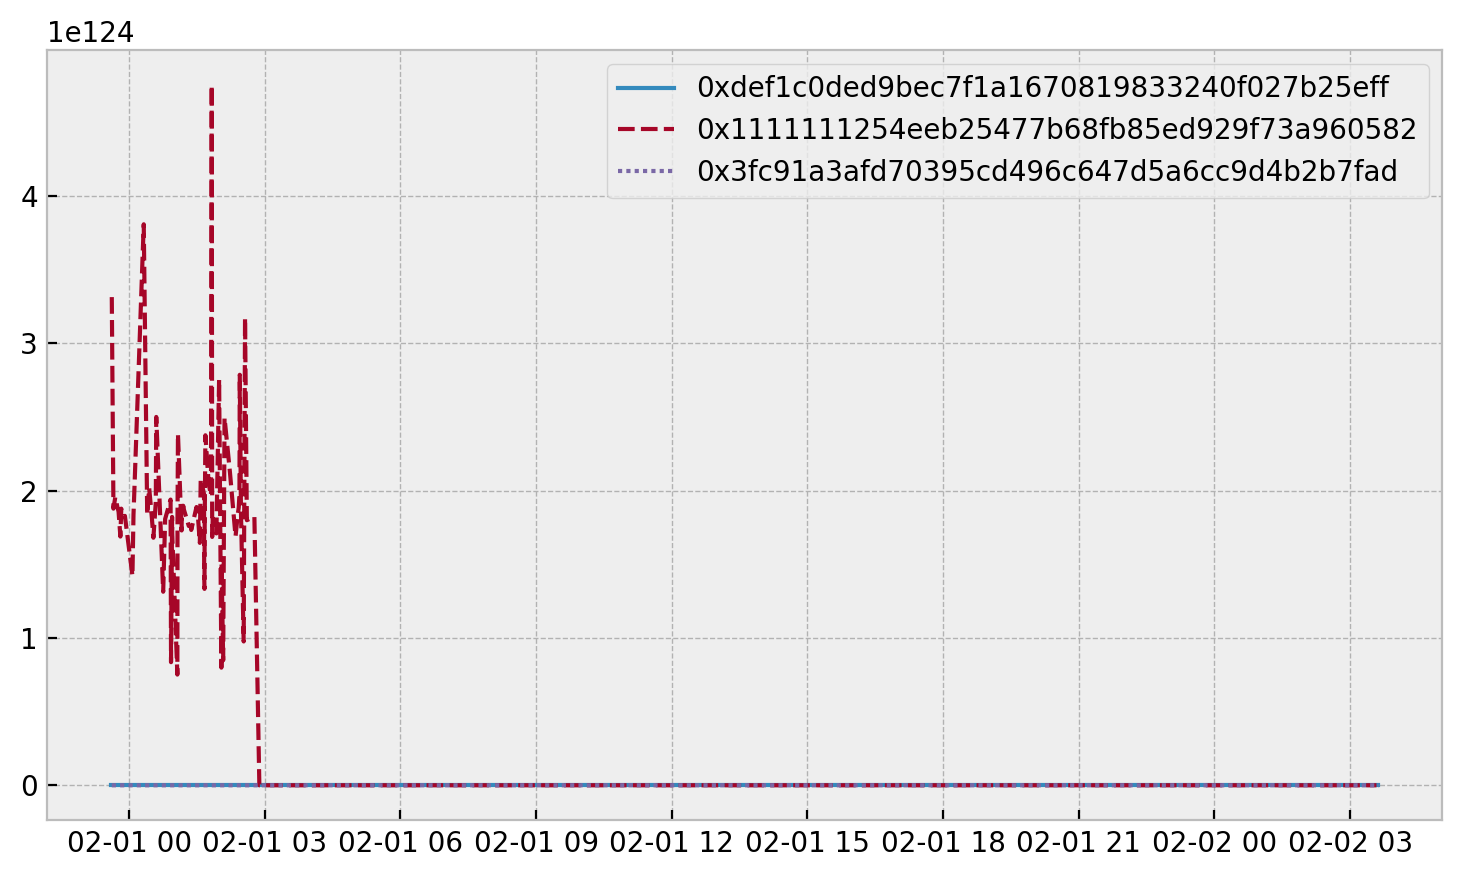

In [69]:
sns.lineplot(cnt_pnls[-3:])